In [1]:
import pandas as pd 
import numpy as np 
import yfinance as yf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import roc_curve, auc
import yfinance as yf
import nltk

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

# **Import data**

In [2]:
headline_url = 'https://raw.githubusercontent.com/BrianNguyen2001/Predict-Etherium-price-by-Machine-Learning/main/headline_ETH_2017_2022.csv'
etherium_inf_url = 'https://raw.githubusercontent.com/BrianNguyen2001/Predict-Etherium-price-by-Machine-Learning/main/eth_blockchain_infomation%20.csv'

In [3]:
# Import data from yahoo.finance
df_btc = yf.download('BTC-USD', 
                       start='2017-11-10', 
                       end='2022-05-30',
                       progress=False)
df_btc.rename(columns={'Open': 'open', "High": 'high', "Low": 'low', "Close": 'close', 'Adj Close': 'adj_close','Volume': 'volume', }, inplace=True)

df_eth = yf.download('ETH-USD', 
                       start='2017-11-10', 
                       end='2022-05-30',
                       progress=False)
df_eth.rename(columns={'Open': 'open', "High": 'high', "Low": 'low', "Close": 'close', 'Adj Close': 'adj_close','Volume': 'volume', }, inplace=True)

df_ltc = yf.download('LTC-USD', 
                       start='2017-11-10', 
                       end='2022-05-30',
                       progress=False)
df_ltc.rename(columns={'Open': 'open', "High": 'high', "Low": 'low', "Close": 'close', 'Adj Close': 'adj_close','Volume': 'volume', }, inplace=True)

crawling_data = pd.read_csv(headline_url,index_col=0)

etherium_inf = pd.read_csv(etherium_inf_url,index_col=0)
etherium_inf.rename(columns={'Average Difficulty': 'avg_diff', "Active Addresses Count": 'act_address', "Average Transaction Fees": 'avg_gas', "Transactions Count": 'trans_count', 'Block Count': 'block_count','Block Size (bytes)': 'block_size', }, inplace=True)

In [4]:
etherium_inf.index = etherium_inf.index.astype('datetime64[ns]')

df_btc = df_btc.adj_close
df_btc.index = df_btc.index.astype('datetime64[ns]')

df_eth = df_eth.adj_close
df_eth.index = df_eth.index.astype('datetime64[ns]')

df_ltc = df_ltc.adj_close
df_ltc.index = df_ltc.index.astype('datetime64[ns]')


In [5]:
# Tạo dataframe dữ liệu để xây dựng mô hình.
data = pd.concat([df_eth,df_btc,df_ltc,etherium_inf],axis=1)
data.columns = ['price_etherium', 'price_bitcoin','price_litecoin', 'avg_diff', 'act_address', 'avg_gas', 'trans_count', 'block_count', 'block_size']
data

,price_etherium,price_bitcoin,price_litecoin,avg_diff,act_address,avg_gas,trans_count,block_count,block_size
Date,,,,,,,,,
2017-11-09,320.884003,7143.580078,64.269699,1.420000e+15,243554,0.222171,467172.0,6195,86289173
2017-11-10,299.252991,6618.140137,59.260101,1.430000e+15,233966,0.191088,457427.0,6300,84500680
2017-11-11,314.681000,6357.600098,62.303299,1.440000e+15,194696,0.186744,394378.0,6267,79370301
2017-11-12,307.907990,5950.069824,59.005402,1.490000e+15,213315,0.210592,434380.0,6245,82639583
2017-11-13,316.716003,6559.490234,61.396500,1.460000e+15,214384,0.220279,443176.0,6225,89907928
...,...,...,...,...,...,...,...,...,...
2022-05-25,1944.827881,29562.361328,68.313118,1.440000e+16,508395,6.325360,1094639.0,6165,633978416
2022-05-26,1803.913330,29267.224609,63.828136,1.420000e+16,474790,8.062978,1071180.0,6092,687245210
2022-05-27,1724.922852,28627.574219,61.563923,1.460000e+16,494940,6.816255,1093469.0,6218,618243706


In [6]:
# Tính toán lợi suất của ETH, BTC and LTC
up_down = data.copy()
up_down[['price_etherium','price_bitcoin','price_litecoin']] = up_down[['price_etherium','price_bitcoin','price_litecoin']].pct_change()

up_down.columns = ['return_etherium','return_bitcoin','return_litecoin','avg_diff', 'act_address', 'avg_gas', 'trans_count', 'block_count', 'block_size']
up_down = up_down.dropna()
up_down

,return_etherium,return_bitcoin,return_litecoin,avg_diff,act_address,avg_gas,trans_count,block_count,block_size
Date,,,,,,,,,
2017-11-10,-0.067411,-0.073554,-0.077946,1.430000e+15,233966,0.191088,457427.0,6300,84500680
2017-11-11,0.051555,-0.039368,0.051353,1.440000e+15,194696,0.186744,394378.0,6267,79370301
2017-11-12,-0.021523,-0.064101,-0.052933,1.490000e+15,213315,0.210592,434380.0,6245,82639583
2017-11-13,0.028606,0.102422,0.040523,1.460000e+15,214384,0.220279,443176.0,6225,89907928
2017-11-14,0.066037,0.011626,0.020899,1.450000e+15,226170,0.235910,475984.0,6122,99374433
...,...,...,...,...,...,...,...,...,...
2022-05-25,-0.017259,-0.003144,-0.028561,1.440000e+16,508395,6.325360,1094639.0,6165,633978416
2022-05-26,-0.072456,-0.009984,-0.065653,1.420000e+16,474790,8.062978,1071180.0,6092,687245210
2022-05-27,-0.043788,-0.021856,-0.035474,1.460000e+16,494940,6.816255,1093469.0,6218,618243706


**Xử lý dữ liệu crawling**

In [7]:
crawling_data.index = crawling_data.index.astype('datetime64[ns]')
crawling_data.drop(['link'],axis=1,inplace=True)
crawling_data

,title
Time,
2017-11-09,DreamTeam Creates the First and Largest Recrui...
2017-11-09,Blockchain Is a Game-Changer for Online Advert...
2017-11-09,Mark Cuban: Here's the best way to invest your...
2017-11-09,'Irrational exuberance' in ICOs but the tech i...
2017-11-09,"Crown (CRW), The Blockchain Startup Platform, ..."
...,...
2022-05-28,Ethereum’s ‘reorg’ issue and other factors led...
2022-05-28,Solana Just Topped Ethereum in Daily NFT Sales...
2022-05-28,Ethereum Founder Vitalik Buterin Defends Algo-...


**Mô tả dữ liệu headline**

In [8]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop=set(stopwords.words('english'))

corpus=[]
new= crawling_data['title'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


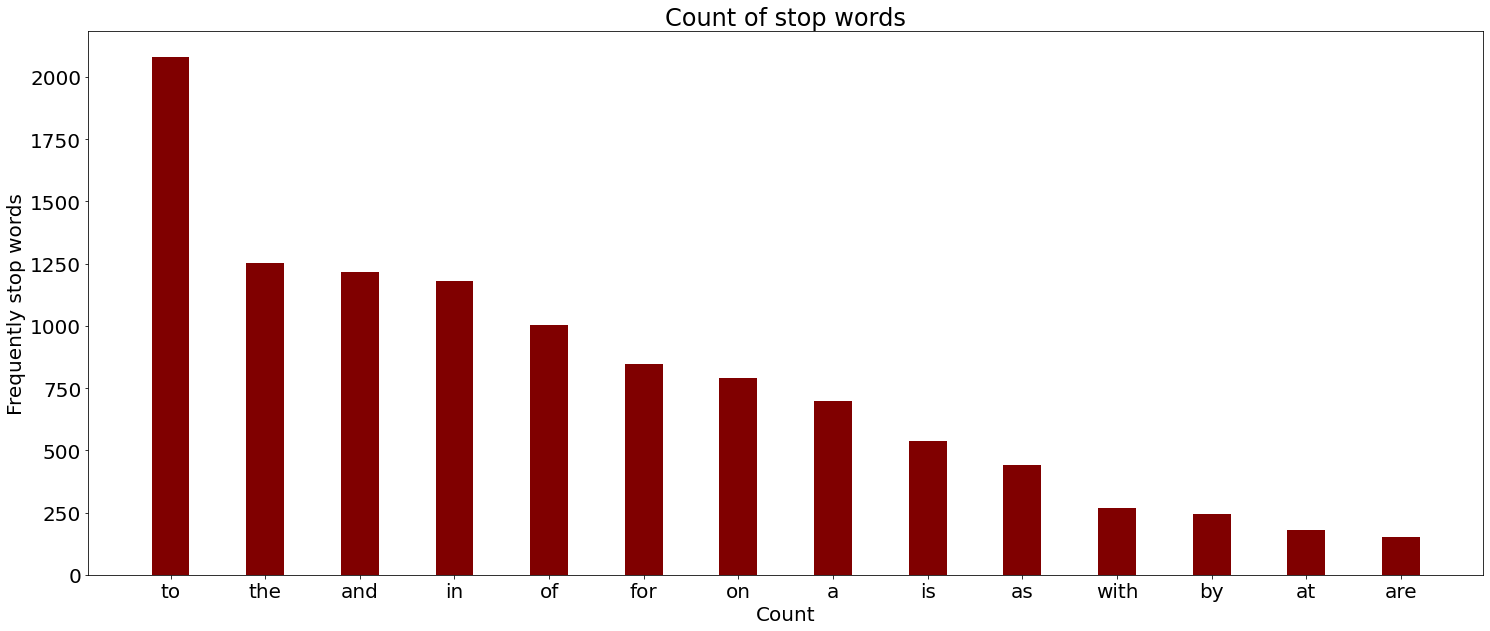

In [9]:
stop_words = pd.DataFrame(dic, index=['Count'])
stop_words = stop_words.T
stop_words = stop_words.sort_values(by='Count',ascending=False)
stop_words = stop_words[stop_words.Count >150]

courses = list(stop_words.index)
values = list(stop_words.Count)
  
fig = plt.figure(figsize = (25,10))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)

plt.xlabel("Count")
plt.ylabel("Frequently stop words")
plt.title("Count of stop words")
plt.show()

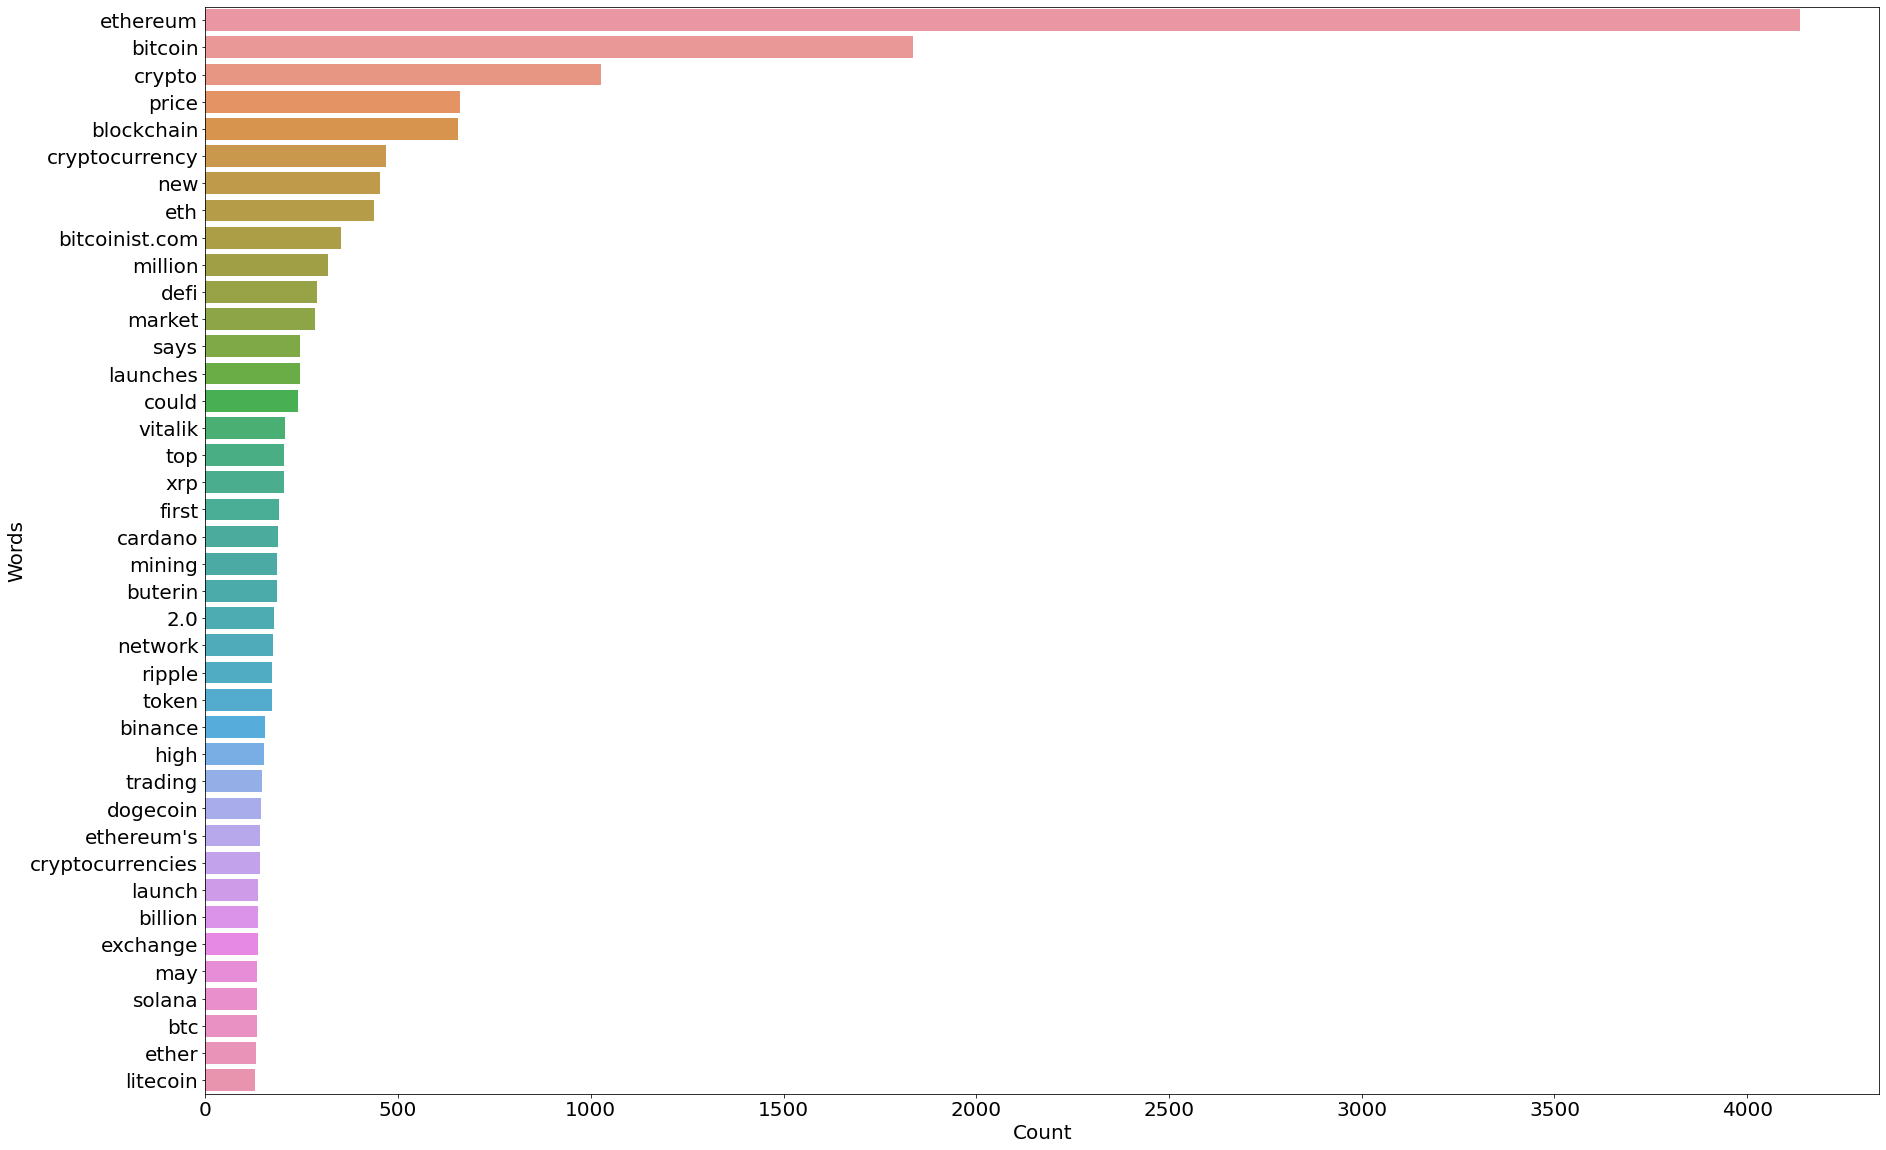

In [10]:
corpus_new = []
for i in corpus:
    i = i.lower()
    i = i.split(',')[0]
    if i not in stop and len(i) > 2:
        corpus_new.append(i)

import seaborn as sns
from collections import Counter
counter=Counter(corpus_new)
most=counter.most_common()

x, y= [], []
for word,count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)

plt.figure(figsize=(30,20))
sns.barplot(x=y,y=x)     
plt.xlabel('Count')
plt.ylabel('Words')

plt.show()

**Sentiments Analysis**

In [11]:
from textblob import TextBlob
import nltk

In [12]:
def polarity_and_subjectivity(df,x_input):
    list_score_polarity = []
    list_score_subjectivity = []

    for i in df.title:
        analysis = TextBlob(i).sentiment
        score_polarity = analysis[0]
        score_subjectivity = analysis[1]
        list_score_polarity.append(score_polarity)
        list_score_subjectivity.append(score_subjectivity)
    
    if x_input == 'polarity':
        return list_score_polarity
    else:
        return list_score_subjectivity

In [13]:
df_sent = crawling_data.copy()
df_sent['polarity'] = polarity_and_subjectivity(df_sent,'polarity')
df_sent['subjectivity'] = polarity_and_subjectivity(df_sent,'subjectivity')
df_sent

,title,polarity,subjectivity
Time,,,
2017-11-09,DreamTeam Creates the First and Largest Recrui...,0.250000,0.333333
2017-11-09,Blockchain Is a Game-Changer for Online Advert...,0.000000,0.000000
2017-11-09,Mark Cuban: Here's the best way to invest your...,0.642857,0.417857
2017-11-09,'Irrational exuberance' in ICOs but the tech i...,0.000000,0.000000
2017-11-09,"Crown (CRW), The Blockchain Startup Platform, ...",0.000000,0.000000
...,...,...,...
2022-05-28,Ethereum’s ‘reorg’ issue and other factors led...,-0.125000,0.375000
2022-05-28,Solana Just Topped Ethereum in Daily NFT Sales...,0.000000,0.000000
2022-05-28,Ethereum Founder Vitalik Buterin Defends Algo-...,0.000000,0.000000


In [14]:
import seaborn as sns
# plt.style.use('fivethirtyeight')

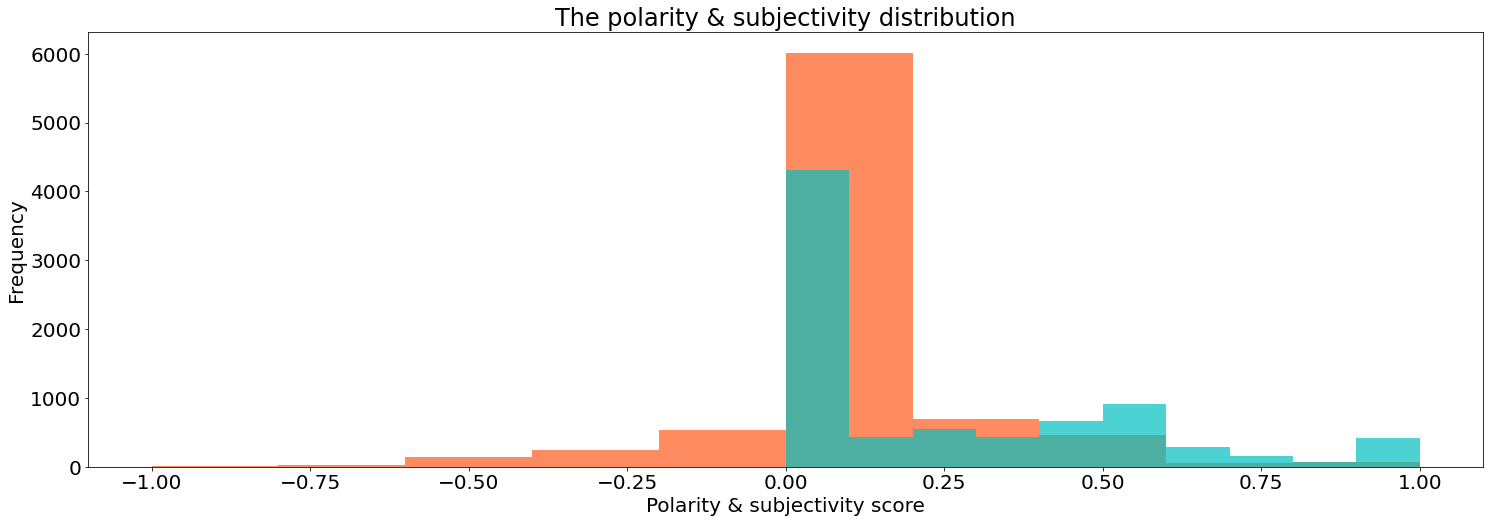

In [15]:
plt.figure(figsize=(25,8))
plt.hist(df_sent.polarity, color='coral', alpha = 0.9)
plt.hist(df_sent.subjectivity, color='c', alpha = 0.7)

plt.title('The polarity & subjectivity distribution')
plt.ylabel('Frequency')
plt.xlabel('Polarity & subjectivity score')
plt.show()

In [16]:
df_sent = df_sent.groupby('Time').mean()
df_sent

,polarity,subjectivity
Time,,
2017-11-09,0.148810,0.125198
2017-11-10,0.000000,0.000000
2017-11-11,0.050000,0.272917
2017-11-12,0.000000,0.000000
2017-11-13,0.116667,0.308333
...,...,...
2022-05-25,0.200000,0.162500
2022-05-26,0.163997,0.277742
2022-05-27,-0.051562,0.317188


**Tính toán pos, neu và neg**

In [17]:
 def getAnalysis(score):
  if score < 0:
    return "Negative"
  elif score == 0:
    return "Neutral"
  else:
    return "Positive"

df_sent["sentiment_analysis"] = df_sent['polarity'].apply(getAnalysis )

In [18]:
df_sent

,polarity,subjectivity,sentiment_analysis
Time,,,
2017-11-09,0.148810,0.125198,Positive
2017-11-10,0.000000,0.000000,Neutral
2017-11-11,0.050000,0.272917,Positive
2017-11-12,0.000000,0.000000,Neutral
2017-11-13,0.116667,0.308333,Positive
...,...,...,...
2022-05-25,0.200000,0.162500,Positive
2022-05-26,0.163997,0.277742,Positive
2022-05-27,-0.051562,0.317188,Negative


In [19]:
dummy = pd.get_dummies(df_sent.sentiment_analysis).iloc[:,[0,2]]
score_sent = pd.concat([df_sent,dummy],axis=1)
score_sent.drop(['sentiment_analysis'],axis=1,inplace=True)
score_sent

,polarity,subjectivity,Negative,Positive
Time,,,,
2017-11-09,0.148810,0.125198,0,1
2017-11-10,0.000000,0.000000,0,0
2017-11-11,0.050000,0.272917,0,1
2017-11-12,0.000000,0.000000,0,0
2017-11-13,0.116667,0.308333,0,1
...,...,...,...,...
2022-05-25,0.200000,0.162500,0,1
2022-05-26,0.163997,0.277742,0,1
2022-05-27,-0.051562,0.317188,1,0


In [20]:
df_finish = pd.concat([score_sent,up_down],axis=1)
df_finish = df_finish[df_finish.return_etherium.notna()]
df_finish

,polarity,subjectivity,Negative,Positive,return_etherium,return_bitcoin,return_litecoin,avg_diff,act_address,avg_gas,trans_count,block_count,block_size
2017-11-10,0.000000,0.000000,0.0,0.0,-0.067411,-0.073554,-0.077946,1.430000e+15,233966.0,0.191088,457427.0,6300.0,84500680.0
2017-11-11,0.050000,0.272917,0.0,1.0,0.051555,-0.039368,0.051353,1.440000e+15,194696.0,0.186744,394378.0,6267.0,79370301.0
2017-11-12,0.000000,0.000000,0.0,0.0,-0.021523,-0.064101,-0.052933,1.490000e+15,213315.0,0.210592,434380.0,6245.0,82639583.0
2017-11-13,0.116667,0.308333,0.0,1.0,0.028606,0.102422,0.040523,1.460000e+15,214384.0,0.220279,443176.0,6225.0,89907928.0
2017-11-14,0.000000,0.000000,0.0,0.0,0.066037,0.011626,0.020899,1.450000e+15,226170.0,0.235910,475984.0,6122.0,99374433.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-25,0.200000,0.162500,0.0,1.0,-0.017259,-0.003144,-0.028561,1.440000e+16,508395.0,6.325360,1094639.0,6165.0,633978416.0
2022-05-26,0.163997,0.277742,0.0,1.0,-0.072456,-0.009984,-0.065653,1.420000e+16,474790.0,8.062978,1071180.0,6092.0,687245210.0
2022-05-27,-0.051562,0.317188,1.0,0.0,-0.043788,-0.021856,-0.035474,1.460000e+16,494940.0,6.816255,1093469.0,6218.0,618243706.0
2022-05-28,0.078125,0.196875,0.0,1.0,0.019142,0.006544,0.012172,1.430000e+16,540980.0,3.731229,1069802.0,6166.0,593458267.0


In [21]:
df_finish.isna().sum()

polarity           91
subjectivity       91
Negative           91
Positive           91
return_etherium     0
return_bitcoin      0
return_litecoin     0
avg_diff            0
act_address         0
avg_gas             0
trans_count         0
block_count         0
block_size          0
dtype: int64

In [22]:
df_finish.fillna(method='ffill',inplace=True)
df_finish.isna().sum()

polarity           0
subjectivity       0
Negative           0
Positive           0
return_etherium    0
return_bitcoin     0
return_litecoin    0
avg_diff           0
act_address        0
avg_gas            0
trans_count        0
block_count        0
block_size         0
dtype: int64

In [23]:
df_finish.index = df_finish.index.set_names('Time')

In [24]:
# df_finish.to_csv('pred_eth_data.csv')